In [1]:
import pandas as pd
from datetime import datetime, timedelta
import os
import json
from tqdm import tqdm
import time

from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
from multiprocessing import Pool

import matplotlib.pyplot as plt

# 1. Concat all the news articles from valid paths

In [2]:
root_dir = '/vast/hd2584/news-please/cc_download_articles_2025_01_03_new'

## a) Original sequential version
The estimated time for reading every news article from json and concat it to a dataframe is around 1h48s. \
We do not finish the run as it takes too long.

In [7]:
t0 = time.time()
paths = []
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.json') and not root.endswith('.mx'):
            paths.append(os.path.join(root, file))
print('- time for getting the list of news article files to process:', time.time()-t0)

# process all files
data_cc = pd.DataFrame()

for file_path in tqdm(paths):
    with open(file_path, 'r', encoding='utf-8') as f:
        article = pd.read_json(file_path)
        data_cc = pd.concat([data_cc, article], ignore_index=True)

- time for getting the list of news article files to process: 26.674832820892334


  0%|          | 1947/903103 [00:13<1:47:54, 139.18it/s]


KeyboardInterrupt: 

## Optimizing gathering json paths
By changing inefficient for loop to list comprehension version, we speed up from 26.67s to 11.30s.

In [3]:
t0 = time.time()
root_dir = Path('/vast/hd2584/news-please/cc_download_articles_2025_01_03_new')

paths = [
    p for p in root_dir.rglob('*.json')
    if not any(parent.name.endswith('.mx') for parent in p.parents)
]

print('- time for getting the list of news article files to process:', time.time()-t0)
print("Gather all valid JSON paths finished!")

- time for getting the list of news article files to process: 11.303631782531738
Gather all valid JSON paths finished!


## b) Multiprocessing
This is an I/O-bound task, as reading those JSON files off disk often spends most of its time waiting on the filesystem. \
Multiprocessing significantly reduces our run time to around 6 minutes!
- Pool() from multiprocessing spins up one worker process per CPU core by default
- Using multiprocessing, when one process waits on the drive, another can be busy reading or parsing. This overlapping of I/O and CPU work typically drives much higher throughput than a single‐threaded loop.

In [7]:
def load_json(path):
    return pd.read_json(path, encoding='utf-8')

dfs = []
with Pool() as pool:
    # pool.imap: yields results in order as they complete
    for df in tqdm(pool.imap(load_json, paths), total=len(paths), desc="Reading JSONs"):
        dfs.append(df)

data_cc = pd.concat(dfs, ignore_index=True)

Reading JSONs: 100%|██████████| 903103/903103 [05:33<00:00, 2707.79it/s]


## c) Threading
The estimated time for threading is around 45 minutes.  \
Threading is slower than multiprocessing due to GIL -  even though I/O can overlap, CPU work still can’t truly run in parallel

In [6]:
def load_json(path):
    return pd.read_json(path, encoding='utf-8')

dfs = []
with ThreadPoolExecutor(max_workers=8) as executor:
    for df in tqdm(executor.map(load_json, paths), total=len(paths), desc="Reading JSONs"):
        dfs.append(df)
        
data_cc = pd.concat(dfs, ignore_index=True)

Reading JSONs:   1%|          | 10504/903103 [00:31<44:54, 331.27it/s] 


KeyboardInterrupt: 

## clean the data

In [18]:
def load_data(df):
    df = df[df['text'].notna()]
    df.drop_duplicates(subset=['text'], keep='first', inplace=True)
    df['date_publish'] = pd.to_datetime(df['date_publish'])
    df['date'] = df['date_publish'].dt.date
    df = df[df['language']=='en']
    df = df.reset_index(drop = True)
    return df

print('- Size before cleaning:', len(data_cc))
data_cc.rename(columns={'maintext': 'text'}, inplace=True)
data = load_data(data_cc)
data = data[['authors', 'date', 'description',  'language', 'text', 'source_domain', 'title', 'url']]
print('- Size after cleaning:', len(data))
data.to_csv("/scratch/hd2584/daily-news-clustering/news/news_large.csv", index = False)

- Size before cleaning: 671522


/state/partition1/job-59625004/ipykernel_2134681/1400007462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['text'], keep='first', inplace=True)
/state/partition1/job-59625004/ipykernel_2134681/1400007462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_publish'] = pd.to_datetime(df['date_publish'])
/state/partition1/job-59625004/ipykernel_2134681/1400007462.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

- Size after cleaning: 490862


## visualize

In [19]:
data = pd.read_csv('/scratch/hd2584/daily-news-clustering/news/news_large.csv')

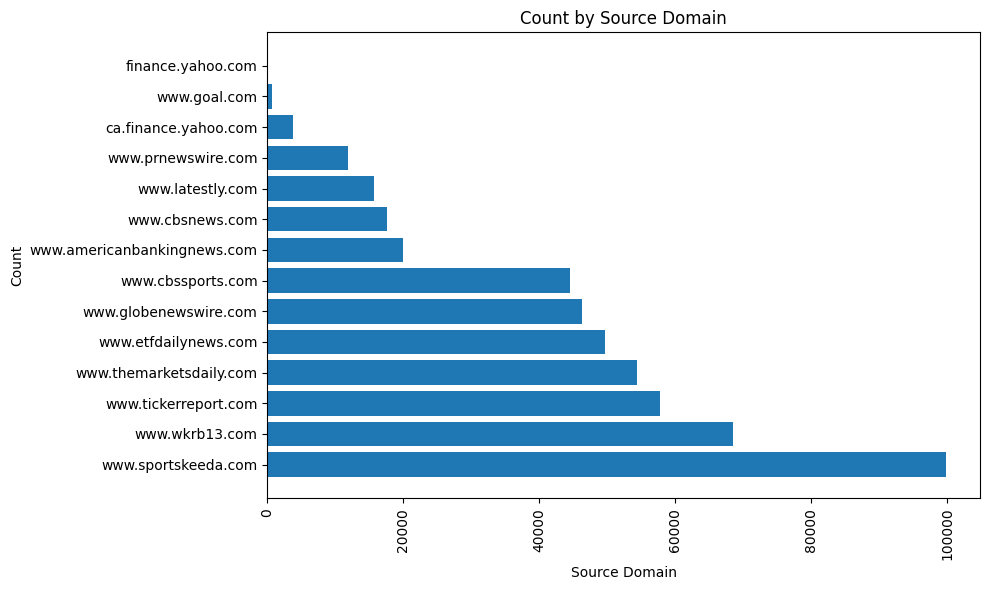

In [11]:
counts = data['source_domain'].value_counts()
plt.figure(figsize=(10, 6))
plt.barh(counts.index.astype(str), counts.values)
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.title("Count by Source Domain")
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

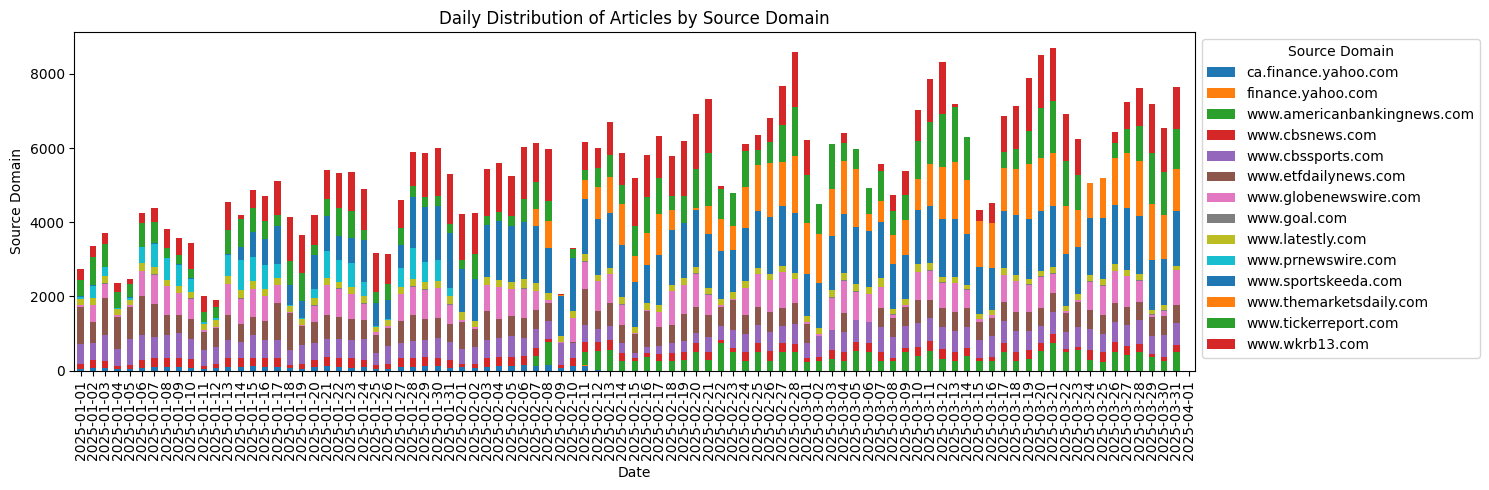

In [12]:
category_counts = data.groupby(['date', 'source_domain']).size().unstack(fill_value=0)

# Plot as a stacked bar chart
category_counts.plot(kind='bar', stacked=True, figsize=(15, 5))

plt.title("Daily Distribution of Articles by Source Domain")
plt.xlabel('Date')
plt.ylabel('Source Domain')
plt.xticks(rotation=90)
plt.legend(title='Source Domain', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## filter news

In [55]:
data_3k = pd.read_csv("/scratch/hd2584/daily-news-clustering/news/news_2025_03.csv")
data_3k.rename(columns={'source': 'source_domain'}, inplace=True)
data_all = pd.concat([data_3k, data])

data_all['date'] = pd.to_datetime(data_all['date'])
data_1 = data_all[data_all['date'].dt.month == 3]
data_1.drop_duplicates(subset=['text'], keep='first', inplace=True)
print(len(data_1))
# data_1 = data_1[data_1['source_domain'] != 'www.wkrb13.com']
# data_1 = data_1[data_1['source_domain'] != 'www.etfdailynews.com']
# data_1 = data_1[data_1['source_domain'] != 'www.americanbankingnews.com']
# data_1 = data_1[data_1['source_domain'] != 'www.themarketsdaily.com']
# data_1 = data_1[data_1['source_domain'] != 'www.tickerreport.com']
# data_1 = data_1[data_1['source_domain'] != 'cbssports']

# data_1.to_csv('/scratch/hd2584/daily-news-clustering/news_update/news_large_2025_03.csv')

207501


/state/partition1/job-59625004/ipykernel_2134681/2099507911.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1.drop_duplicates(subset=['text'], keep='first', inplace=True)


In [56]:
domain_ls = data_1['source_domain'].unique()
for domain in domain_ls:
    print(domain)

http://cnn.com
http://www.cnbc.com
http://washingtonpost.com
http://www.npr.org
www.americanbankingnews.com
www.cbsnews.com
www.cbssports.com
www.etfdailynews.com
www.globenewswire.com
www.goal.com
www.latestly.com
www.sportskeeda.com
www.themarketsdaily.com
www.tickerreport.com
www.wkrb13.com


In [60]:
# examples
for domain in domain_ls:
    print(domain)
    temp = data_1[data_1['source_domain'] == domain]
    for i in range(5):
        print('-', temp['title'].iloc[i])

http://cnn.com
- Video: Matthew Chance: Russians show support for Trump following White House meeting with Zelensky
- Inside the 139 minutes that upended the US-Ukraine alliance
- Zelensky says Trump’s backing is ‘crucial’ after US president berated him at White House
- Head of federal watchdog agency fired by Trump should remain on the job, judge rules
- Bryan Kohberger trial: Defense signals it will focus on challenging DNA evidence
http://www.cnbc.com
- Trump objected to Zelenskyy's tone and body language in Oval Office clash, White House says
- Zelenskyy seeks support at emergency European summit after bruising Trump encounter
- NATO's Rutte urges Zelenskyy to mend his relationship with Trump
- Microsoft resolves global outage that left tens of thousands unable to access email and other apps
- Another 'near miss': Citigroup mistakenly credited a customer account with $81 trillion
http://washingtonpost.com
- Fresh Musk emails to workers lead to renewed pushback at federal agencies
-

In [61]:
len(data_1)

207501

In [62]:
data_sampled = (
    data_1
    .groupby('source_domain', group_keys=False)
    .apply(lambda grp: grp.sample(n=6000, replace=False) 
           if len(grp) >= 6000 else grp)
    .reset_index(drop=True)
)

/state/partition1/job-59625004/ipykernel_2134681/2773693087.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(n=6000, replace=False)


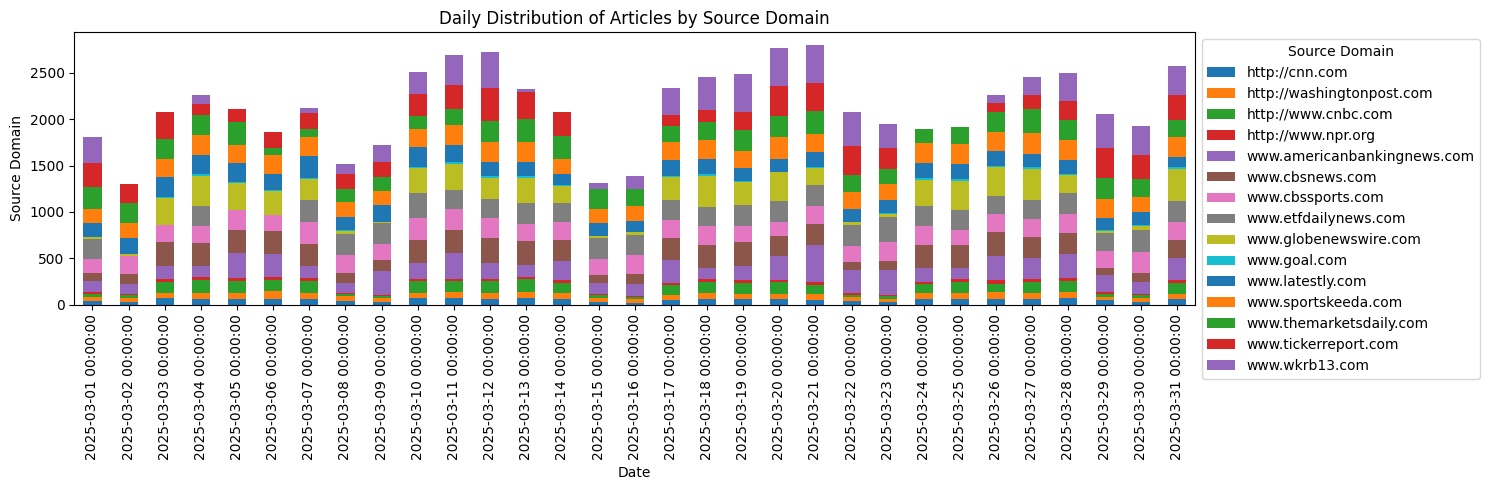

In [63]:
category_counts = data_sampled.groupby(['date', 'source_domain']).size().unstack(fill_value=0)

# Plot as a stacked bar chart
category_counts.plot(kind='bar', stacked=True, figsize=(15, 5))

plt.title("Daily Distribution of Articles by Source Domain")
plt.xlabel('Date')
plt.ylabel('Source Domain')
plt.xticks(rotation=90)
plt.legend(title='Source Domain', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [64]:
def sample_up_to_1000(grp):
    n = min(len(grp), 1000)
    return grp.sample(n=n, replace=False, random_state=42)
    
data_final = (
    data_sampled
    .groupby('date', group_keys=False)
    .apply(sample_up_to_1000)
    .reset_index(drop=True)
)

/state/partition1/job-59625004/ipykernel_2134681/4095354290.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sample_up_to_1000)


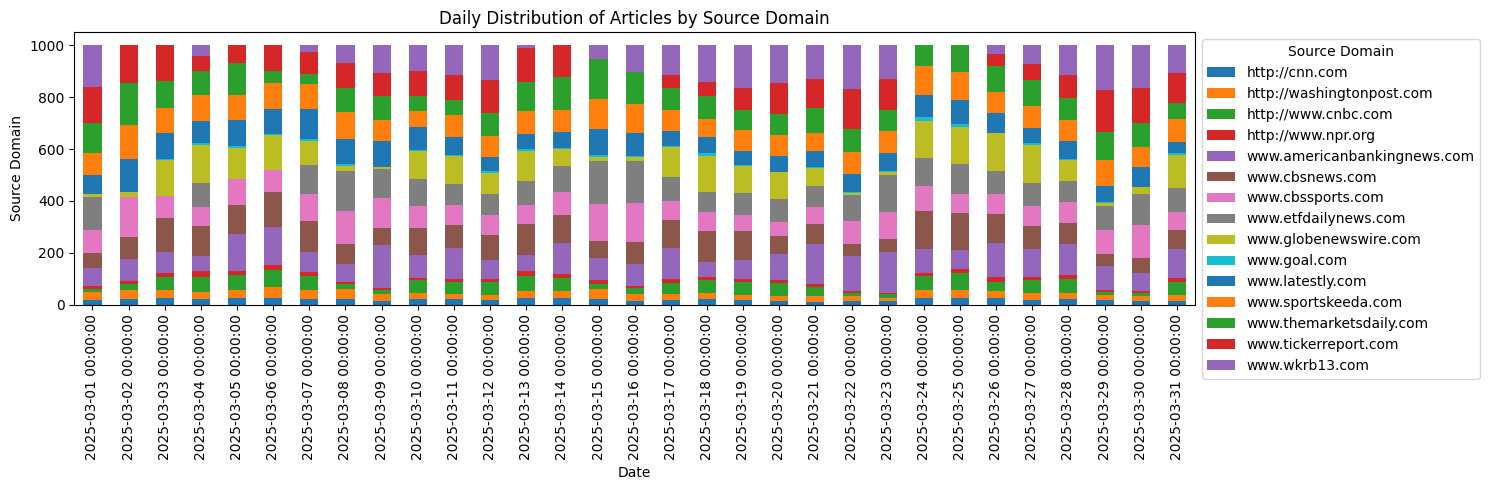

In [65]:
category_counts = data_final.groupby(['date', 'source_domain']).size().unstack(fill_value=0)

# Plot as a stacked bar chart
category_counts.plot(kind='bar', stacked=True, figsize=(15, 5))

plt.title("Daily Distribution of Articles by Source Domain")
plt.xlabel('Date')
plt.ylabel('Source Domain')
plt.xticks(rotation=90)
plt.legend(title='Source Domain', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [67]:
data_final[data_final['date']<='2025-03-15'].to_csv("/scratch/hd2584/daily-news-clustering/news/news_2025-03-01_2025-03-15.csv", index=False)

In [44]:
# data_final.to_csv("/scratch/hd2584/daily-news-clustering/news/news_2025-03.csv", index=False)